<a href="https://colab.research.google.com/github/aguscura/UBA-data-science/blob/main/spark_S17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**S17:** La antigüedad promedio de los usuarios y el nombre del usuario más antiguo cuyas última review contenga la palabra ‘pizza’ (2 PUNTOS)


In [49]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.n

In [50]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
from datetime import date
from datetime import datetime, timedelta

In [ ]:
!gdown "1owjSBHKLx0pJMdQYtKUIfiXqBV3lfCdS"

In [52]:
#Creamos el Spark Context
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Paso el csv a parquet. Por un tema de RAM solo me traigo algunas columnas

In [53]:
#Chequeo columnas del df
df = pd.read_csv("/content/user.csv")
df.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

# **La antigüedad promedio de los usuarios**

In [54]:
#Paso a parquet. Acá solo tomo algunas columnas por el RAM
df = pd.read_csv("/content/user.csv", usecols=["user_id","name","yelping_since"])
df.to_parquet("/content/user.parquet")

In [55]:
#Leemos archivo parquet
sqlContext = SQLContext(sc)
rdd = sqlContext.read.parquet('/content/user.parquet').rdd.repartition(2)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [56]:
# rdd.take(5)

In [57]:
rdd_antiguedad = rdd.map(lambda x: (x.user_id, (x.name, (datetime.now() - datetime.strptime(x.yelping_since, '%Y-%m-%d %H:%M:%S')).days))).cache()
#lo cacheo porque voy a tener mas de una accion + join abajo

In [58]:
total = rdd_antiguedad.count()
total

1987897

In [59]:
rdd_antiguedad.take(5)

[('qVc8ODYU5SZjKXVBgXdI7w', ('Walker', 5744)),
 ('j14WgRoU_-2ZE1aw1dXrJg', ('Daniel', 5014)),
 ('2WnXYQFK0hXEoTxPtV2zvg', ('Steph', 5198)),
 ('SZDeASXq7o05mMNLshsdIA', ('Gwen', 6167)),
 ('hA5lMy-EnncsH4JoR-hFGQ', ('Karen', 5764))]

In [60]:
sum = rdd_antiguedad.map(lambda x: x[1][1]).reduce(lambda a,b: a+b)
sum

5829767284

In [61]:
mean = sum/total
print(mean)

2932.6304551996404


**ANTIGUEDAD PROMEDIO EN DÍAS: 2932.63**

***Importante --> El resultado está sujeto al momento en que se corre la notebook porque compara con la fecha 'datetime.now()'***


#**Nombre del usuario más antiguo cuya última review contenga la palabra ‘pizza'**

In [ ]:
!gdown "1okxCrPipVJmexBSVZ34kJlttw02-7kTX"

**Para el review.csv, no hago el pasaje a parquet porque no me da el RAM**

In [63]:
# df = pd.read_csv("/content/review.csv")
# df.columns

In [64]:
# df = pd.read_csv("/content/review.csv", usecols=["user_id","text", "date"])
# df.to_parquet("/content/review.parquet")

In [65]:
#Leemos archivo parquet
# sqlContext = SQLContext(sc)
# rdd_2 = sqlContext.read.parquet('/content/review.parquet').rdd.repartition(2)

In [66]:
sqlContext = SQLContext(sc)
df = sqlContext.read.csv('/content/review.csv', header=True, inferSchema=True)
rdd_2 = df.rdd

In [67]:
# rdd_2.take(5)

Voy a buscar **para cada user** la ultima review que contenga la palabra pizza.  Primero filtro por aquellas review que tengan fecha (para que sean comparables y buscar la ultima) y también filtro por las reviews **no nulas** que tengan la palabra pizza.

Algunos campos estaban 'sucios'. "date" tenía reviews por ejemplo, entonces cuando lo quise pasar al formato fecha me tiraba error. (Ver imágen)

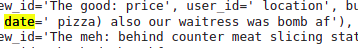

In [68]:
# rdd_2.map(lambda x: (x.user_id, (x.date, x.text))).filter(lambda x:  (x[1][0] != None)   and   (x[1][1] != None)  ).filter(lambda x: "pizza" in x[1][1]).take(3)

***Filtro el campo 'date' buscando las str que efectivamente tengan formato fecha:*** Filtro por el tamaño del string (exactamente 19 caracteres, que contenga ":" y también "-". Eso logra filtrarme unicamente las fechas. Luego paso a formato fecha y **para cada key (user) me quedo solo con el registro de fecha más grande (más actual)**.

IMPORTANTE --> No encontré nada similar a lo de la práctica que filtraban con str.isnumeric() para ver si el string solo contenia números. En este caso como eran fechas no encontre nada aplicable.

In [69]:
rdd_3 = rdd_2.map(lambda x: (x.user_id, (x.date, x.text))).filter(lambda x:  (x[1][0] != None)   and   (x[1][1] != None)  ).filter(lambda x: "pizza" in x[1][1])\
.filter(lambda x:  (len(x[1][0]) == 19)  and   (":" in x[1][0] )  and  ("-" in x[1][0])    )\
.reduceByKey(lambda a,b: a if  datetime.strptime(a[0], '%Y-%m-%d %H:%M:%S') > datetime.strptime(b[0], '%Y-%m-%d %H:%M:%S') else b).cache()
#cacheo el rdd_3 porque voy a chequear con 'take' y luego tengo el join.

In [70]:
rdd_3.take(5)

[('iYwyZB3O28cXcuy5Sfl_yw',
  ('2017-07-28 23:41:16',
   "Finally! Great pizza & knots at the beach!!! Excellent location with a cool street presence. These guys know what they're doing.")),
 ('bUUPVJ7l6vWSvZV1W8G8Bw',
  ('2017-09-09 03:15:00',
   'Came late Friday night for a bite to eat. Much of the soup, hot takeaway were cleaned up. Settled for an individual pizza to share. Crust was too thick, but we could debate pies until the cows come home. Wandered the store while it was baking and found Scharffenberger chocolate! Pie may not be up to our standard but the chocolate hit the spot. At 8pm at night, the staff was exhausted')),
 ('TA_McHKN9QEM73JJFXv3Cw',
  ('2018-07-08 00:19:27',
   'It really upsets me that Five Star pizza does NOT have five stars. Really great pizza. Do not get the cinnamon bite things. The pepperoni bites are super yummy. Their pizzas are very large and nicely priced. Always coupons/deals on their website when you order. Food is usually ready to be picked up in

Ahora que ya tengo la ultima review con la palabra pizza de cada user (obviamente algunos users no tienen). Hago un join con 'rdd_antiguedad' que **también tiene el id del user como Key**, y luego el nombre y la antiguedad. 



In [71]:
#Chequeo. Ambos rdd están cacheados (rdd_antiguedad y rdd_3)
rdd_final = rdd_antiguedad.join(rdd_3)
rdd_final.take(2)

[('AHRrG3T1gJpHvtpZ-K0G_g',
  (('Brittany', 4193),
   ('2020-11-19 12:57:04',
    "Dedicating my #ThankYouThursday review to Mass Ave Wine shop. I've probably visited this cozy little wine shop for over a decade now and seem to appreciate it even more in the era of COVID. You begin to realize all of the life and fun action that happens in a space when you no longer can have it. Mass Ave Wine is known for hosting tasting nights, mini massages, game nights and so on. It feels like your neighborhood bar with a little extra pizzazz. We often find ourselves here to pick up a quick bottle of wine or explore their Vermouth and mixer options. The staff is very friendly and knowledgeable. During COVID, they're carryout only but you can still find all of the bottles and good vibes you'd expect on a regular day."))),
 ('Jv9Kb_Ldbjgw9VEtjtWjfQ',
  (('jessica', 4609),
   ('2021-08-22 19:50:02',
    "Wine is good and the location is pretty. Sitting out in the vines is wonderful during nice weather. 

**Busco el user más antiguo**
  
user_id = key

(user_id ,  ( (nombre, *dias de antiguedad en yelp*) , (fecha ultima noticia con la palabra pizza , noticia con la palabra pizza)  )   )

x[1][0][1] --> Antiguedad

In [72]:
rdd_final.reduce(lambda a,b: a if a[1][0][1] > b[1][0][1] else b)

('HrdxjjW4Z9WHWYGjWzaq6g',
 (('mykeah', 6559),
  ('2021-11-03 02:02:15',
   'Such good pizza! Their crust is bomb and their gluten free options are awesome! Get the breadsticks...so good! This has become our favorite pizza in town.')))

El user más antiguo cuya ultima review posee la palabra pizza es **mykeah** (user_id = HrdxjjW4Z9WHWYGjWzaq6g) y su review es: **'Such good pizza! Their crust is bomb and their gluten free options are awesome! Get the breadsticks...so good! This has become our favorite pizza in town.'**